In [1]:
import pandas as pd
import numpy as np
import timm
import torchvision.transforms as T
import torch
import itertools
from torch.optim import SGD
from transformers import AutoImageProcessor, AutoModel
import torch.nn as nn
import os

from wildlife_tools.train import ArcFaceLoss, BasicTrainer, set_seed, TripletLoss, InfoNCELoss
from wildlife_tools.features import DeepFeatures
from wildlife_tools.data import ImageDataset


/home/users/dash/guppies/embeddings/wildlife-tools/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:


# Load metadata
PT_CSV = '/home/users/dash/guppies/embeddings/wildlife-tools/exploring/csvs/top_10_individuals.csv'
# PT_CSV = '/home/users/dash/guppies/embeddings/wildlife-tools/exploring/csvs/no_id.csv'
PT_images = '/gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks'
PT_storage = '/gws/nopw/j04/iecdt/dash/embeddings'
df = pd.read_csv(PT_CSV)
# df['path'] = df['path'].str.replace('.JPG','.png', case=False)
# df.to_csv(PT_CSV, index=False)
print(len(df))
df.head()


304


,identity,path,date
0,63498,1706/Lower Lalaja/29A/DCIM/121D7100/DSC_8870.png,2017-06-29
1,63498,1803/LL/26B/123D7100/DSC_3857.png,2018-03-26
2,63498,1804/LL/27B/DSC_5389.png,2018-04-27
3,63498,1802/LL/26B/DSC_0428.png,2018-02-26
4,63498,1806/LL/28A/100D7100/DSC_9352.png,2018-06-28


In [3]:
# Add a column 'identity' with random integers as labels
# num_identities = 10000  # or any number of unique identities you want
# df['identity'] = np.random.randint(0, num_identities, size=len(df))
df = df[:100000]
print(len(df))
print(df.head())
df.to_csv(PT_CSV[:-4]+'_100000.csv', index=False)
# df.to_csv(PT_CSV, index=False)

100000
                    path  identity
0  0803/DSC_15480201.png       467
1  0803/DSC_15500202.png       822
2  0803/DSC_15530205.png       494
3  0803/DSC_15540206.png       866
4  0803/DSC_15550207.png       725


# Model setup

In [4]:
# Load the MegaDescriptor model
# backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-L-384', pretrained=True, num_classes=0)
# backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-T-224', pretrained=True, num_classes=0)


# Load the processor and model
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-small', use_fast=True)
backbone = AutoModel.from_pretrained('facebook/dinov2-small')


In [142]:
# freeze all parameters in the backbone
for param in backbone.parameters():
    param.requires_grad = False

# The DINOv2 model from Hugging Face has an encoder with a list of layers.
# unfreeze the last two layers. DINOv2-small has 12 layers (0-11).
layers_to_train = [10, 11]
for name, param in backbone.named_parameters():
    for layer_num in layers_to_train:
        if f"encoder.layer.{layer_num}." in name:
            param.requires_grad = True

In [5]:
import pynvml

pynvml.nvmlInit()
device_count = torch.cuda.device_count()
max_free_mem = 0
best_device = 0

for i in range(device_count):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    if mem_info.free > max_free_mem:
        max_free_mem = mem_info.free
        best_device = i

device = torch.device(f'cuda:{best_device}')
print(f'using gpu {device}, {torch.cuda.device_count()} available')

using gpu cuda:1, 4 available


In [6]:
class SafeImageDataset(ImageDataset):
    """ImageDataset that skips unreadable images and logs their paths."""

    def __init__(self, *args, log_file: str | None = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.log_file = log_file

    def __getitem__(self, idx):
        attempts = 0
        start_idx = idx
        while attempts < len(self.metadata):
            data = self.metadata.iloc[idx]
            img_path = os.path.join(self.root, data[self.col_path]) if self.root else data[self.col_path]
            try:
                img = self.get_image(img_path)
            except (FileNotFoundError, ValueError):
                if self.log_file:
                    with open(self.log_file, "a") as f:
                        f.write(f"{img_path}\n")
                idx = (idx + 1) % len(self.metadata)
                attempts += 1
                continue

            if self.transform:
                img = self.transform(img)
            if self.load_label:
                return img, self.labels[idx]
            return img

        raise RuntimeError("No valid images found starting from index " f"{start_idx}")

In [7]:
# 2. Split the data into train and query sets
train_rows = []
query_rows = []
val_ratio = 0.1

# Group by each ID
for name, group in df.groupby('identity'):
    # Sort the images for that ID by date
    group = group.sort_values(by='date')
    
    # Skip IDs with only one image, as they can't be split
    if len(group) < 2:
        train_rows.append(group)
        continue

    # Determine the split point
    n_val = int(np.ceil(len(group) * val_ratio)) # np.ceil ensures at least 1 for val if ratio > 0
    n_train = len(group) - n_val

    # Append rows to the correct lists
    train_rows.append(group.head(n_train))
    query_rows.append(group.tail(n_val))

# Concatenate the lists of rows into final DataFrames
train_df = pd.concat(train_rows)
query_df = pd.concat(query_rows)


In [8]:

print(f"Train set size: {len(train_df)}")
print(f"Query set size: {len(query_df)}")
print(f'total size: {len(train_df) + len(query_df)}')

# Verify that all IDs in the query set are present in the train set
query_ids = set(query_df['identity'].unique())
train_ids = set(train_df['identity'].unique())

print(f"\nQuery IDs: {len(query_ids)}")
print(f"Train IDs: {len(train_ids)}")

assert query_ids.issubset(train_ids)

print("\nVerification successful: All IDs in the query set are present in the train set.")

Train set size: 270
Query set size: 34
total size: 304

Query IDs: 10
Train IDs: 10

Verification successful: All IDs in the query set are present in the train set.


In [9]:

# Define image transformations
transform = T.Compose([
    T.Resize((224, 224)),  # Resize to match MegaDescriptor-L-384 input
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
transform_dino = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# query_df = df.sample(frac=0.2, random_state=42)
# database_df = df.drop(query_df.index)
# Save the query and database splits to CSV files
# query_df.to_csv(PT_CSV[:-4] + '_query.csv', index=False)
# train_df.to_csv(PT_CSV[:-4] + '_database.csv', index=False)

# Create ImageDataset instances

query_dataset = SafeImageDataset(query_df, root=PT_images, transform=transform_dino,log_file='unreadable_images.txt')
database_dataset = SafeImageDataset(train_df, root=PT_images, transform=transform_dino, log_file='unreadable_images.txt')

# query_dataset = ImageDataset(query_df, root=PT_images, transform=transform_dino)
# database_dataset = ImageDataset(database_df, root=PT_images, transform=transform_dino)

In [15]:
print(f"Query dataset size: {len(query_dataset)}")
print(f"Database dataset size: {len(database_dataset)}")
query_ids = set(query_dataset.metadata['identity'].unique())
database_ids = set(database_dataset.metadata['identity'].unique())
all_query_ids_in_database = query_ids.issubset(database_ids)
print(f"All query IDs in database: {all_query_ids_in_database}")
print('ids in query dataset:', len(query_dataset.metadata['identity'].unique()))
print('ids in database dataset:', len(database_dataset.metadata['identity'].unique()))

Query dataset size: 0
Database dataset size: 183441
All query IDs in database: True
ids in query dataset: 0
ids in database dataset: 29997


In [10]:
# Define a wrapper to extract features
class DINOv2Wrapper(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone

    def forward(self, x):
        # Extract the last hidden state
        outputs = self.backbone(x)
        # Use the [CLS] token representation
        return outputs.last_hidden_state[:, 0]

In [27]:
# check images work!!!!!
from PIL import Image

# Function to check if all images in a dataset can be opened
def check_images(dataset, root):
    failed = []
    for idx in range(len(dataset)):
        img_path = dataset.iloc[idx]['path']
        full_path = f"{root}/{img_path}"
        print(f"Checking image: {full_path}")
        try:
            with Image.open(full_path) as img:
                img.verify()  # Verify that it is, in fact, an image
        except Exception as e:
            print(f"Failed to open: {full_path} ({e})")
            failed.append(full_path)
    if not failed:
        print("All images opened successfully!")
    else:
        print(f"{len(failed)} images failed to open.")
    return failed

print("Checking database_dataset...")
failed_db = check_images(database_df, PT_images)

print("Checking query_dataset...")
failed_query = check_images(query_df, PT_images)

Checking database_dataset...
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1706/Lower Lalaja/29A/DCIM/121D7100/DSC_8870.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1803/LL/26B/123D7100/DSC_3857.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1804/LL/27B/DSC_5389.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1802/LL/26B/DSC_0428.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1806/LL/28A/100D7100/DSC_9352.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1807/LL/26B/124D7100/DSC_2617.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1902/LL/27B/110D7100.1/DSC_4155.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1901/Lower Lalaja/27B/DSC_2536.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1908/Lower Lalaja/27B/DSC_0257.pn

# Training

In [147]:

'''
Args:
    margin (int): Margin for triplet loss.
    mining (str): Type of triplet mining. One of: 'all', 'hard', 'semihard'
    distance (str): Distance metric for triplet loss. One of: 'cosine', 'l2', 'l2_squared'''

objective = TripletLoss(
    margin=0.5,
    mining='semihard',
    distance='l2_squared'
)


"""
Wraps Pytorch Metric Learning ArcFaceLoss.

Args:
    num_classes (int): Number of classes.
    embedding_size (int): Size of the input embeddings.
    margin (int): Margin for ArcFace loss (in radians).
    scale (int): Scale parameter for ArcFace loss.
"""
# Define the loss function
objective = ArcFaceLoss(
    num_classes=database_dataset.num_classes,
    embedding_size=backbone.config.hidden_size,
    margin=0.5,
    scale=64
)

objective = InfoNCELoss(temperature=0.1)

params_to_train = []
for name, param in backbone.named_parameters():
    if param.requires_grad:
        params_to_train.append(param)
        # print(f"Training parameter: {name}")

# If objective has learnable parameters (like ArcFaceLoss), add them
if hasattr(objective, 'parameters'):
    params_to_train.extend(objective.parameters())

# Define the optimizer
# params = itertools.chain(backbone.parameters(), objective.parameters())
optimizer = SGD(params=params_to_train, lr=0.001, momentum=0.9)

# Set the seed for reproducibility
set_seed(0)
epochs = 20
# Initialize the trainer
trainer = BasicTrainer(
    dataset=database_dataset,
    model=DINOv2Wrapper(backbone),
    objective=objective,
    optimizer=optimizer,
    epochs=epochs,
    device=device)

In [128]:
# Start training
trainer.train()

Epoch 10:  50%|███████████████████████████▌                           | 1/2 [00:08<00:08,  8.23s/it]


KeyboardInterrupt: 

In [110]:
# Save the model's state_dict
torch.save(backbone.state_dict(), PT_storage+f'/DINO_{epochs}_arcface_-2unfrozen.pth')

In [11]:
# checkpoint = torch.load(PT_storage+f'/DINO_{epochs}_epoch_arcface.pth', map_location=device)
PT_SSLDINO_100 = '/home/users/dash/guppies/embeddings/wildlife-tools/exploring/runs/run-76d175dz/teacher_epoch_9.pt'
PT_SSLDINO_10000 = '/gws/nopw/j04/iecdt/dash/embeddings/models/run-e8dzdu9a/teacher_epoch_9.pt'
PT_SSLDINO_100000 = '/gws/nopw/j04/iecdt/dash/embeddings/models/run-3z9528dj/teacher_epoch_9.pt'
PT_SSLDINO_new_100 = '/gws/nopw/j04/iecdt/dash/embeddings/models/dino/unsupervised/dino-small_selfsup_100/teacher_epoch_9.pt'
checkpoint = torch.load(PT_SSLDINO_new_100, map_location=device)
# Load the state_dict into the backbone
print(checkpoint.keys())
# backbone.load_state_dict(checkpoint)

odict_keys(['backbone.embeddings.cls_token', 'backbone.embeddings.mask_token', 'backbone.embeddings.position_embeddings', 'backbone.embeddings.patch_embeddings.projection.weight', 'backbone.embeddings.patch_embeddings.projection.bias', 'backbone.encoder.layer.0.norm1.weight', 'backbone.encoder.layer.0.norm1.bias', 'backbone.encoder.layer.0.attention.attention.query.weight', 'backbone.encoder.layer.0.attention.attention.query.bias', 'backbone.encoder.layer.0.attention.attention.key.weight', 'backbone.encoder.layer.0.attention.attention.key.bias', 'backbone.encoder.layer.0.attention.attention.value.weight', 'backbone.encoder.layer.0.attention.attention.value.bias', 'backbone.encoder.layer.0.attention.output.dense.weight', 'backbone.encoder.layer.0.attention.output.dense.bias', 'backbone.encoder.layer.0.layer_scale1.lambda1', 'backbone.encoder.layer.0.norm2.weight', 'backbone.encoder.layer.0.norm2.bias', 'backbone.encoder.layer.0.mlp.fc1.weight', 'backbone.encoder.layer.0.mlp.fc1.bias', '

In [12]:
# Remove 'backbone.' prefix from all keys in the checkpoint
new_checkpoint = {k.replace("backbone.", ""): v for k, v in checkpoint.items()}

backbone.load_state_dict(new_checkpoint, strict=False)  # strict=False ignores unexpected keys

_IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.last.weight'])

# Inference

In [13]:
model = DINOv2Wrapper(backbone)
model.to(device)

extractor = DeepFeatures(model, device=device)

# Extract features
with torch.no_grad():
    features = extractor(database_dataset)


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.87s/it]


In [11]:
assert len(features) == len(database_dataset)
assert tuple(features.features.shape) == (len(database_dataset), 384) # 768 for base model, 384 for small model

In [14]:
# Convert embeddings to NumPy array
embeddings = features.features
if isinstance(embeddings, torch.Tensor):
    embeddings = embeddings.detach().cpu().numpy()

# Extract labels
labels = features.labels_string  # Assuming labels are stored here

# TSNE

In [15]:
from sklearn.manifold import TSNE

# Determine the number of samples
n_samples = embeddings.shape[0]

# Set perplexity to a value less than n_samples
perplexity_value = min(5, n_samples - 1)

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(embeddings)


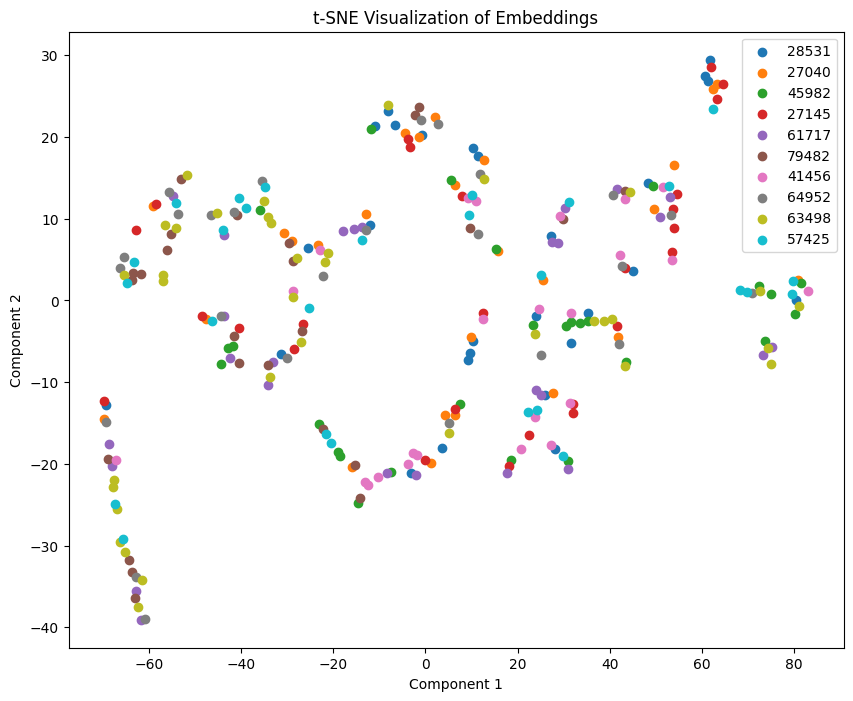

In [16]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(10, 8))
unique_labels = set(labels)
# for label in unique_labels:
#     indices = [i for i, l in enumerate(labels) if l == label]
#     plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label)

# Select 10 random labels from unique_labels
random_labels = random.sample(list(unique_labels), 10)

for label in random_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label)

plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [17]:
from wildlife_tools.similarity import CosineSimilarity
from wildlife_tools.inference import KnnClassifier
import numpy as np



# Extract features
query_features = extractor(query_dataset)
database_features = features
# database_features = extractor(database_dataset)


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


# Cosine similarity

In [18]:

# Compute cosine similarity
similarity_function = CosineSimilarity()
similarity = similarity_function(query_features, database_features)

# Perform 1-NN classification
classifier = KnnClassifier(k=1, database_labels=database_dataset.labels_string)
predictions = classifier(similarity)

# Evaluate accuracy
accuracy = np.mean(np.array(query_dataset.labels_string) == np.array(predictions))
print(f'1-NN Classification Accuracy: {accuracy:.2%}')


1-NN Classification Accuracy: 14.71%


In [17]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings)
# Initialize dictionaries to hold similarities
same_identity_sims = defaultdict(list)
different_identity_sims = defaultdict(list)

num_embeddings = len(embeddings)

for i in range(num_embeddings):
    for j in range(i + 1, num_embeddings):
        sim = similarity_matrix[i][j]
        if labels[i] == labels[j]:
            same_identity_sims[labels[i]].append(sim)
        else:
            key = f"{labels[i]} vs {labels[j]}"
            different_identity_sims[key].append(sim)

# Compute average similarities
avg_same_identity_sim = np.mean([np.mean(sims) for sims in same_identity_sims.values()])
avg_different_identity_sim = np.mean([np.mean(sims) for sims in different_identity_sims.values()])

print(f"Average similarity within the same identity: {avg_same_identity_sim:.4f}")
print(f"Average similarity between different identities: {avg_different_identity_sim:.4f}")

Average similarity within the same identity: 0.9989
Average similarity between different identities: 0.9987


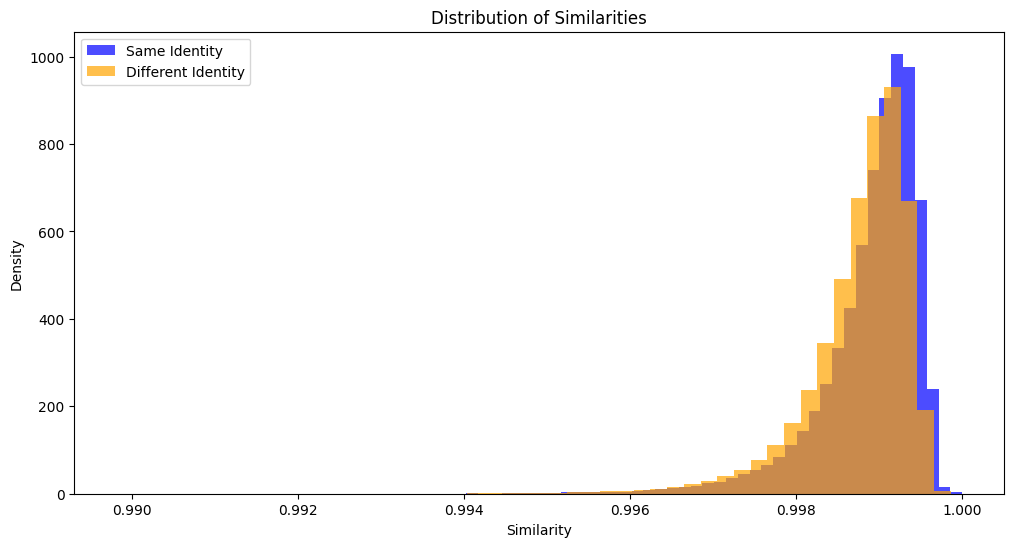

In [18]:
plt.figure(figsize=(12, 6))

# Flatten the lists of similarities
same_identity_flat = [sim for sims in same_identity_sims.values() for sim in sims]
different_identity_flat = [sim for sims in different_identity_sims.values() for sim in sims]

# Plot histograms
plt.hist(same_identity_flat, bins=50, alpha=0.7, label='Same Identity', color='blue', density=True)
plt.hist(different_identity_flat, bins=50, alpha=0.7, label='Different Identity', color='orange', density=True)

# Add labels and legend
plt.title('Distribution of Similarities')
plt.xlabel('Similarity')
plt.ylabel('Density')
plt.legend()

plt.show()

# euclidean distance

In [19]:
from scipy.spatial.distance import cdist

# Calculate pairwise distances
distances = cdist(query_features.features, database_features.features, metric='euclidean')

In [20]:
from sklearn.preprocessing import MinMaxScaler

# Normalize distances using Min-Max scaling
scaler = MinMaxScaler()
normalized_distances = scaler.fit_transform(distances)

In [21]:
# For each query, find the database sample with the smallest distance (1-NN)
knn_predictions = []
for i in range(distances.shape[0]):
    min_idx = np.argmin(distances[i])
    knn_predictions.append(database_dataset.labels_string[min_idx])

# Calculate accuracy
knn_accuracy = np.mean(np.array(query_dataset.labels_string) == np.array(knn_predictions))
print(f'1-NN Classification Accuracy (using distances): {knn_accuracy:.2%}')

1-NN Classification Accuracy (using distances): 3.49%
